# ADS577 FINAL PROJECT 
# PREDICTION ENEGRY DEMAND WITH NEURAL NETWORKS(LSTM AND GRU)

### IMPORT REQUIRED PACKAGES 

In [ ]:
# Model Packages
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error
# Standard Packages

import pandas as pd
import missingno as mnso
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import warnings
import re


### CONSUMPTION DATA IDENTIFICATION 

In [ ]:
# Running this cell will provide you with a token to link your drive to this notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
import pandas as pd
DATAPATH="drive/My Drive/Colab Notebooks/ads577-finalproject/demand_realtime.csv"
data = pd.read_csv(DATAPATH , index_col=['Date'], parse_dates=['Date'])
print(data.describe())
print(data.head())

In [ ]:
data=pd.read_csv('consumption_realtime.csv', encoding= 'unicode_escape')

In [ ]:
data.head()

,Tarih,Saat,Tüketim Miktarý (MWh)
0,31.12.2015,00:00,"29.590,88"
1,31.12.2015,01:00,"27.785,43"
2,31.12.2015,02:00,"26.516,53"
3,31.12.2015,03:00,"26.091,62"
4,31.12.2015,04:00,"25.871,54"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61416 entries, 0 to 61415
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tarih                  61416 non-null  object
 1   Saat                   61416 non-null  object
 2   Tüketim Miktarý (MWh)  61416 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


In [ ]:
data.describe(include = 'all')

,Tarih,Saat,Tüketim Miktarý (MWh)
count,61416,61416,61416
unique,2559,24,60459
top,31.12.2015,04:00,"31.913,39"
freq,24,2560,3


### Change Column Name

In [ ]:
data.rename(columns={'Tarih': 'date', 'Saat': 'hour', 'Tüketim Miktarý (MWh)':'demand'}, inplace=True)

In [ ]:
data.head()

,date,hour,demand
0,31.12.2015,00:00,"29.590,88"
1,31.12.2015,01:00,"27.785,43"
2,31.12.2015,02:00,"26.516,53"
3,31.12.2015,03:00,"26.091,62"
4,31.12.2015,04:00,"25.871,54"


### Data Cleaning and Transformation

All features are described as Object but demand must be float and date and hour must join and describe as an index for dataset.

In [ ]:
data['new_date']=pd.to_datetime(data['date'] + ' ' + data['hour'])

In [ ]:
#df=data.drop(['date','hour',axis=1)

In [ ]:
data.head()

,date,hour,demand,new_date
0,31.12.2015,00:00,"29.590,88",2015-12-31 00:00:00
1,31.12.2015,01:00,"27.785,43",2015-12-31 01:00:00
2,31.12.2015,02:00,"26.516,53",2015-12-31 02:00:00
3,31.12.2015,03:00,"26.091,62",2015-12-31 03:00:00
4,31.12.2015,04:00,"25.871,54",2015-12-31 04:00:00


### Convert demand from object to float

In [ ]:
data["demand"] = [float(str(i).replace(",", "")) for i in data["demand"]]

In [ ]:
data['demand']=data['demand'].astype(float)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61416 entries, 0 to 61415
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      61416 non-null  object        
 1   hour      61416 non-null  object        
 2   demand    61416 non-null  float64       
 3   new_date  61416 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 1.9+ MB


### PRODUCTION DATA IDENTIFICATION 

In [ ]:
production=pd.read_csv('production.csv', encoding= 'unicode_escape')

In [ ]:
DATAPATH="drive/My Drive/Colab Notebooks/ads577-finalproject/demand_realtime.csv"
production = pd.read_csv(DATAPATH , index_col=['Date'], parse_dates=['Date'])
print(production.describe())


In [ ]:
production.head()

,Tarih,Saat,Toplam (MWh),Doðal Gaz,Barajlý,Linyit,Akarsu,Ýthal Kömür,Rüzgar,Güneþ,Fuel Oil,Jeotermal,Asfaltit Kömür,Taþ Kömür,Biyokütle,Nafta,LNG,Uluslararasý,Atýk Isý
0,27.05.2023,00:00,"34.126,66","7.048,87","6.491,58","4.162,08","4.466,03","6.510,66","2.151,90","0,00","94,36","1.177,46","172,22","568,25","878,38","0,00","0,00","330,93","73,94"
1,27.05.2023,01:00,"32.532,94","5.958,31","6.040,38","4.170,32","4.507,14","6.483,25","2.047,45","0,00","94,76","1.189,04","172,22","567,67","868,39","0,00","0,00","358,71","75,30"
2,27.05.2023,02:00,"31.375,92","5.176,61","5.257,92","4.248,88","4.474,52","6.745,23","2.067,21","0,00","95,36","1.199,54","174,43","564,63","866,89","0,00","0,00","431,82","72,88"
3,27.05.2023,03:00,"30.348,08","4.096,13","5.110,49","4.346,77","4.472,96","6.758,89","2.113,32","0,00","94,04","1.206,61","172,22","570,37","873,53","0,00","0,00","458,24","74,51"
4,27.05.2023,04:00,"30.021,26","3.596,13","5.342,83","4.445,43","4.405,45","6.844,82","1.906,10","0,00","94,20","1.214,12","172,22","573,39","898,31","0,00","0,00","456,31","71,95"


In [ ]:
production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Tarih           17 non-null     object
 1   Saat            17 non-null     object
 2   Toplam (MWh)    17 non-null     object
 3   Doðal Gaz       17 non-null     object
 4   Barajlý         17 non-null     object
 5   Linyit          17 non-null     object
 6   Akarsu          17 non-null     object
 7   Ýthal Kömür     17 non-null     object
 8   Rüzgar          17 non-null     object
 9   Güneþ           17 non-null     object
 10  Fuel Oil        17 non-null     object
 11  Jeotermal       17 non-null     object
 12  Asfaltit Kömür  17 non-null     object
 13  Taþ Kömür       17 non-null     object
 14  Biyokütle       17 non-null     object
 15  Nafta           17 non-null     object
 16  LNG             17 non-null     object
 17  Uluslararasý    17 non-null     object
 18  Atýk Isý    

### EXPLONATORY DATA ANALYSIS

In [ ]:

    data["week"] = data.apply(lambda x: x["new_date"].dayofweek, axis=1)
    data["month"] = data.apply(lambda x: x["new_date"].month, axis=1)
    data["year"] = data.apply(lambda x: x["new_date"].dayofyear, axis=1)
    data.head()

NameError: name 'data' is not defined

### Demand Decsribe Property according to date

In [ ]:
demand_by_hour=data.groupby('hour').agg({'demand':['skew', 'mean', 'std', 'var', 
                                                   'median','sum', 'min', 'max']}).reset_index()
demand_by_hour

hour    demand                                                          \
               skew       mean       std        var     median          sum   
0   00:00  0.368881  32.156269  3.413473  11.651801  31.927400  82287.89324   
1   01:00  0.399648  30.568460  3.342997  11.175630  30.359240  78224.69025   
2   02:00  0.096985  29.441953  3.301954  10.902902  29.208750  75341.95693   
3   03:00  0.358652  28.723678  3.171482  10.058295  28.484795  73475.16882   
4   04:00  0.312711  28.383622  3.093142   9.567528  28.173305  72662.07313   
5   05:00  0.080258  28.179773  3.003206   9.019244  28.141340  72112.03901   
6   06:00 -0.318876  28.282017  3.084903   9.516628  28.597220  72373.68200   
7   07:00 -0.357008  29.636908  3.625149  13.141704  29.881290  75840.84655   
8   08:00 -0.492629  33.410656  4.856386  23.584487  33.878040  85497.86986   
9   09:00 -0.483648  35.791871  5.441664  29.611706  36.257220  91591.39820   
10  10:00 -0.358626  36.722141  5.516020  30.426481  37.000380  93971.95859   
11  11:00 -0.262967  37.375184  5.584001  31.181062  37.450110  95643.09499   
12  12:00 -0.043244  36.233486  5.323214  28.336612  36.194130  92721.49077   
13  13:00  0.014459  36.600592  5.375569  28.896739  36.409730  93660.91514   
14  14:00 -0.011258  37.271131  5.575016  31.080801  37.091670  95376.82409   
15  15:00  0.002873  37.075317  5.459857  29.810035  36.951410  94875.73604   
16  16:00 -0.056457  37.142224  5.270029  27.773205  37.116340  95046.95021   
17  17:00 -0.181462  37.199345  4.903112  24.040505  37.413350  95193.12371   
18  18:00 -0.325199  37.054935  4.284731  18.358918  37.333410  94823.57774   
19  19:00 -0.234136  37.078191  3.872953  14.999769  37.274110  94883.08958   
20  20:00  0.101830  36.970713  3.822136  14.608722  36.987410  94608.05432   
21  21:00  0.209489  36.301210  3.764957  14.174902  36.249470  92894.79699   
22  22:00  0.229443  35.523371  3.594695  12.921836  35.367190  90904.30587   
23  23:00  0.258684  34.064254  3.520342  12.392807  33.885770  87170.42566   

                        
         min       max  
0   20.62768  44.98442  
1   19.38121  43.18165  
2    0.00000  41.70162  
3   17.58637  40.53457  
4   17.25550  39.93522  
5   16.38907  39.24862  
6   15.59552  38.29132  
7   15.33330  40.66264  
8   15.48926  46.30844  
9   15.81402  50.34422  
10  16.50711  52.34596  
11  17.16911  54.05308  
12  17.41520  53.42077  
13  17.17475  54.30215  
14  16.92506  55.57502  
15  16.62264  55.17541  
16  17.23753  54.29478  
17  18.44238  52.57890  
18  19.95350  49.61565  
19  21.29081  48.92610  
20  22.88382  50.04723  
21  23.00792  49.44350  
22  22.36699  48.20676  
23  21.63952  46.57529

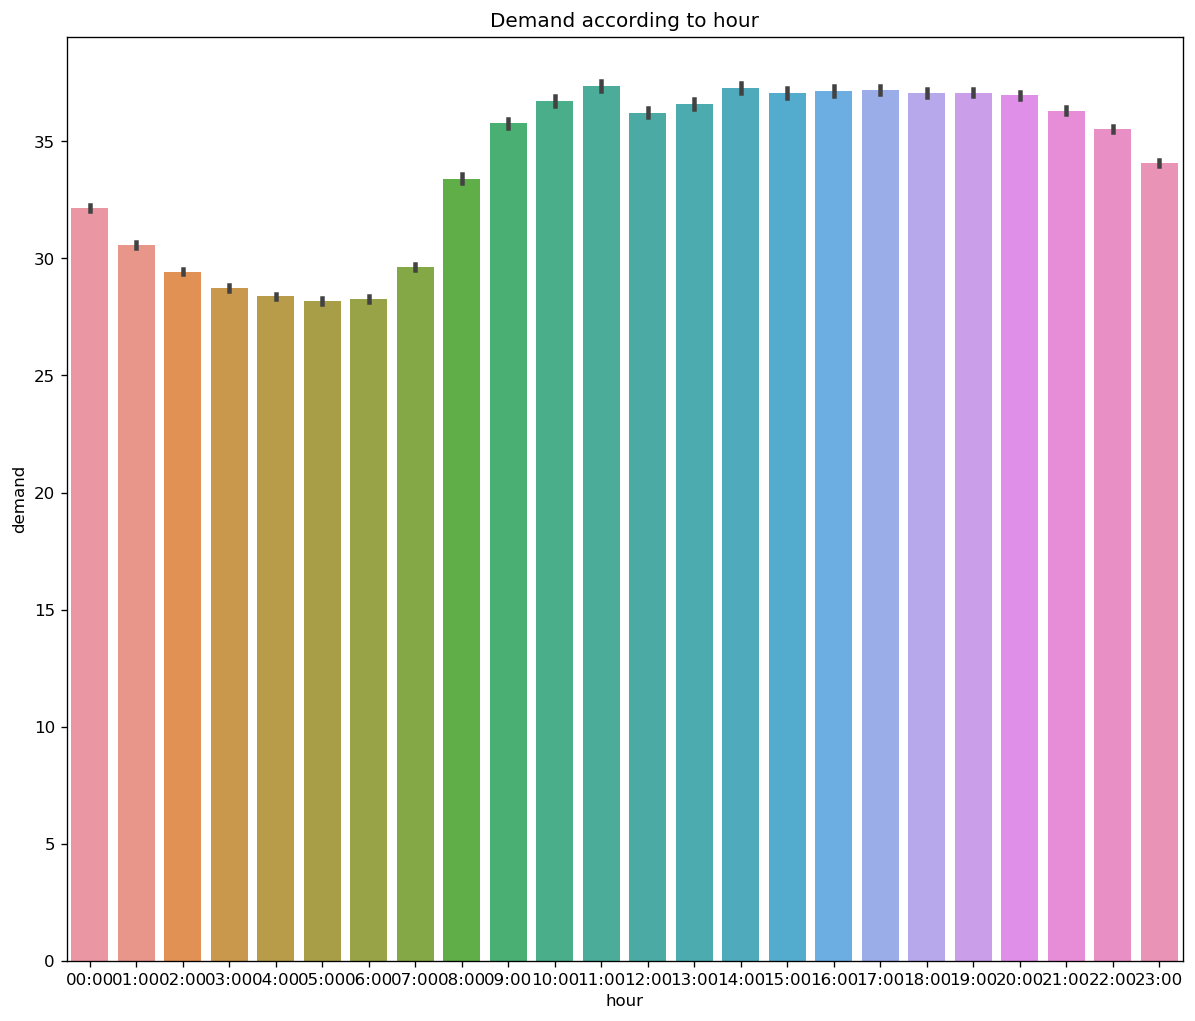

In [ ]:
plt.figure(figsize= (12,10))
sns.barplot(x = "hour", y = "demand",data = data)
plt.title('Demand according to hour')
plt.show()

### Demand Decsribe Property according to date

In [ ]:
demand_by_date=data.groupby('date').agg({'demand':['skew', 'mean', 'std', 'var', 
                                                   'median','sum', 'min', 'max']}).reset_index()
demand_by_date

date    demand                                             \
                     skew       mean       std        var     median   
0    2015-12-31  0.076227  31.628514  4.340196  18.837299  31.084435   
1    2016-01-01 -0.340399  27.028717  3.461561  11.982407  28.429170   
2    2016-01-02 -0.488773  31.794606  5.143901  26.459722  33.000145   
3    2016-01-03 -0.606729  29.139808  2.987354   8.924286  30.523825   
4    2016-01-04 -0.568711  30.269956  2.919464   8.523269  31.341000   
...         ...       ...        ...       ...        ...        ...   
2554 2022-12-28 -0.625705  37.092968  4.366383  19.065304  39.043160   
2555 2022-12-29 -0.623803  36.692115  4.264855  18.188992  38.866650   
2556 2022-12-30 -0.549273  35.674623  3.886417  15.104240  37.208225   
2557 2022-12-31 -0.199605  32.321599  2.678893   7.176468  32.900930   
2558 2023-01-01  0.254163  28.742940  3.288416  10.813678  28.922940   

                                     
            sum       min       max  
0     759.08433  25.87154  37.76872  
1     648.68921  21.84416  32.04802  
2     763.07055  23.85461  37.77508  
3     699.35539  24.22634  32.51051  
4     726.47894  25.45617  34.21405  
...         ...       ...       ...  
2554  890.23123  29.70146  41.84730  
2555  880.61077  29.56349  41.33402  
2556  856.19095  29.14333  40.44165  
2557  775.71837  28.13467  36.34395  
2558  689.83056  24.39520  34.37826  

[2559 rows x 9 columns]

### Demand Graph according to date

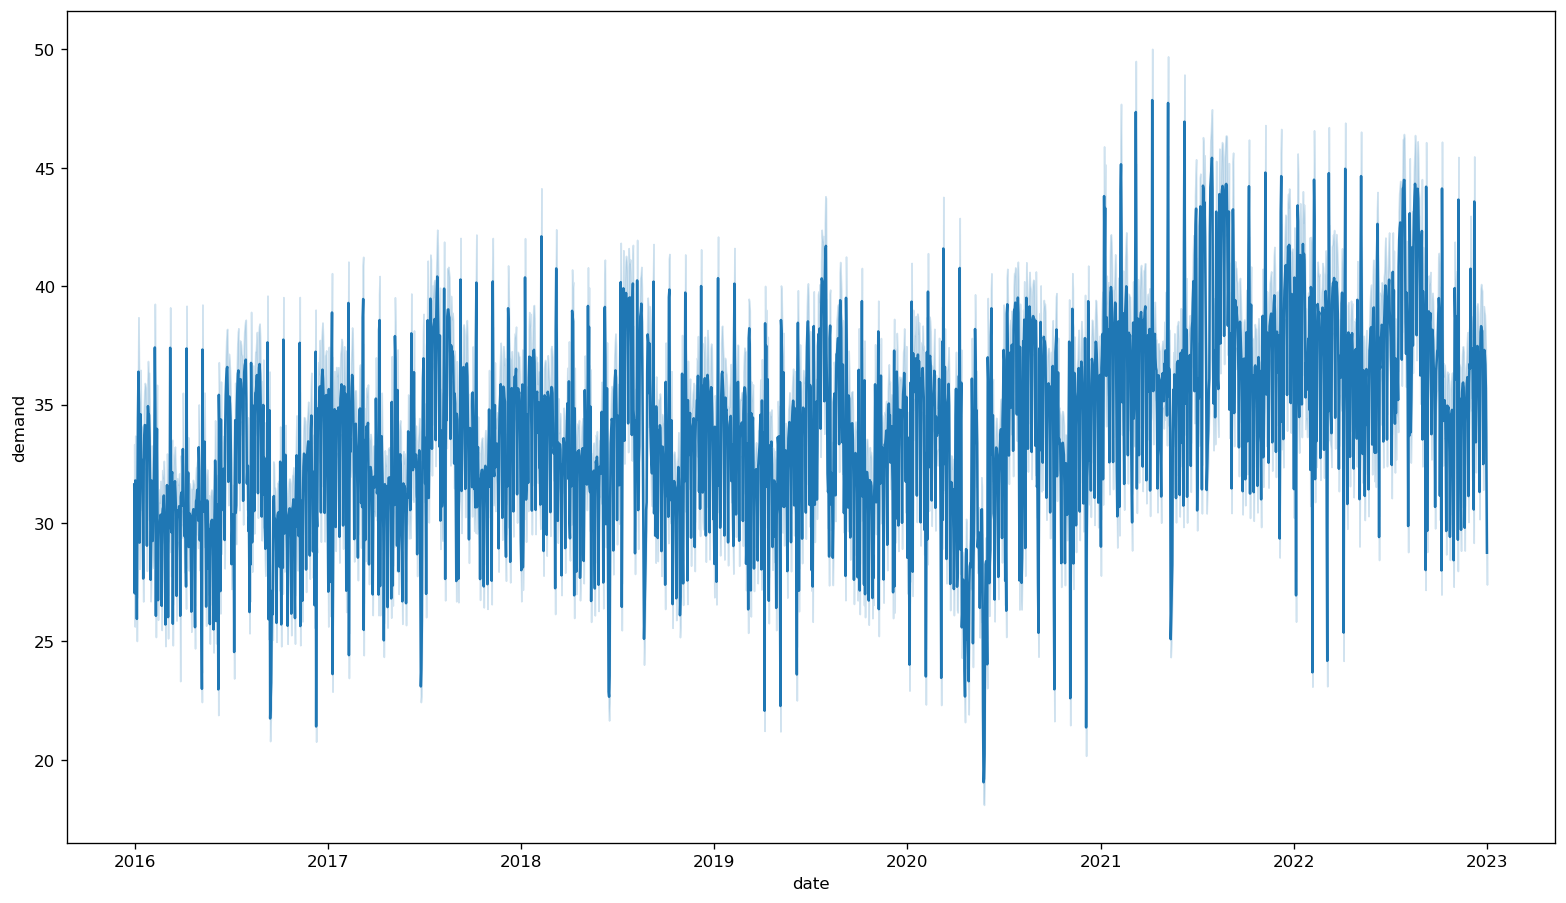

In [ ]:
fig=plt.subplots(figsize=(16,9))
sns.lineplot(data=data, x="date",y="demand")
plt.show()

### Mean of Demand graph with px plot

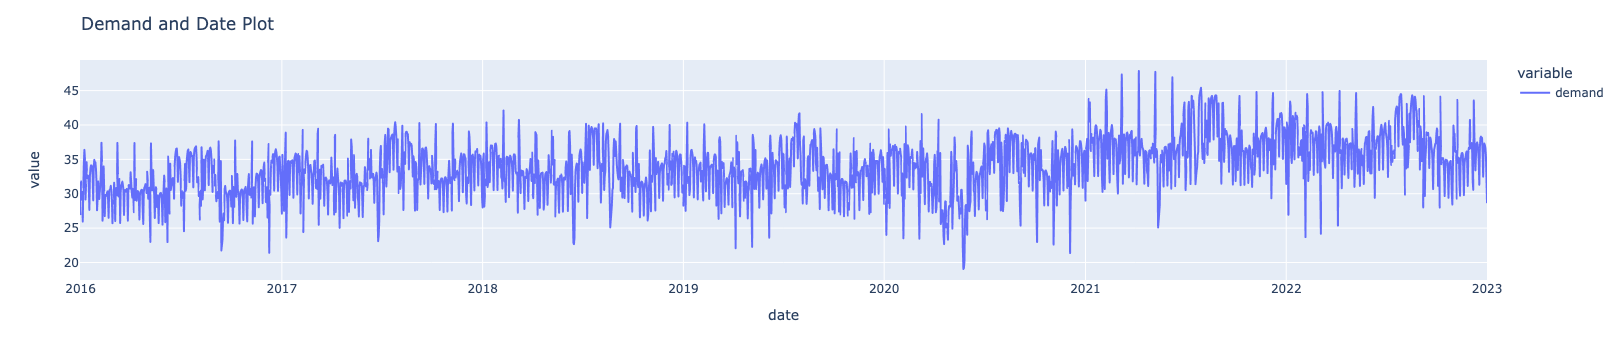

In [ ]:
import plotly.express as px
grouped = data.groupby(['date']).agg({'demand': 'mean'})
fig = px.line(grouped, x=grouped.index , y=['demand'])
fig.update_layout(title='Demand and Date Plot')
fig.show()

### HOURLY DEMAND BOX PLOT

In [ ]:
plt.figure(figsize = (15, 7))
ax = sns.boxplot(x=df['Date'].dt.hour, y="Consumption (MWh)", data=df)
plt.title('Hourly Consumption', fontsize=11)

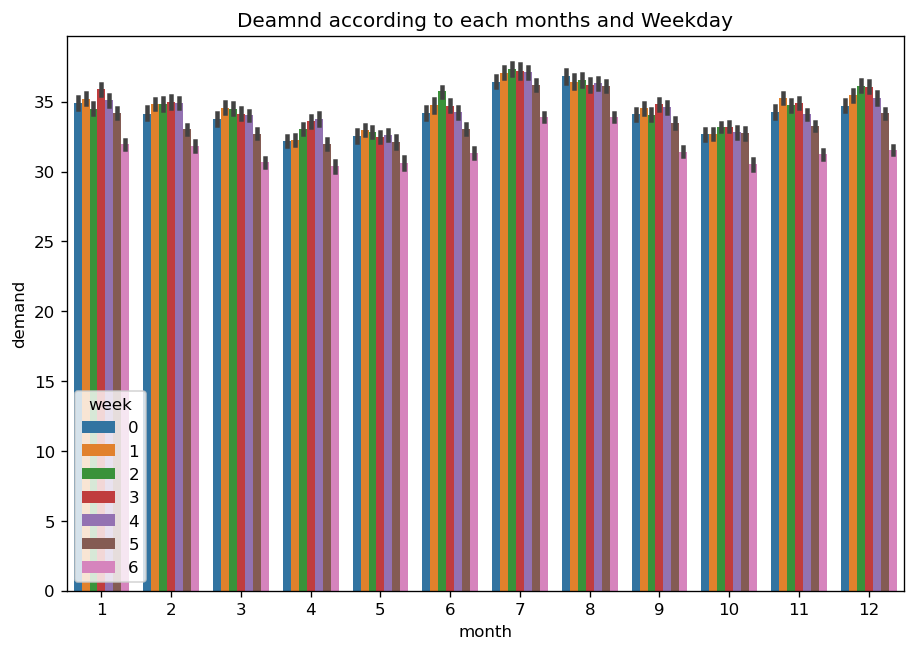

In [ ]:
plt.figure(figsize= (9,6))
sns.barplot(x = "month", y = "demand",hue = 'week' ,data = data)
plt.title('Deamnd according to each months and Weekday')
plt.show() 

### CHECK SEASONALITYOF TOTAL SALES

A seasonality is observed when there is a distinct repeated pattern observed between regular intervals due to seasonal factors. It could be because of the month of the year, the day of the month, weekdays or even time of the day. However, It is not mandatory that all time series must have a trend and/or seasonality. A time series may not have a distinct trend but have a seasonality and vice-versa.

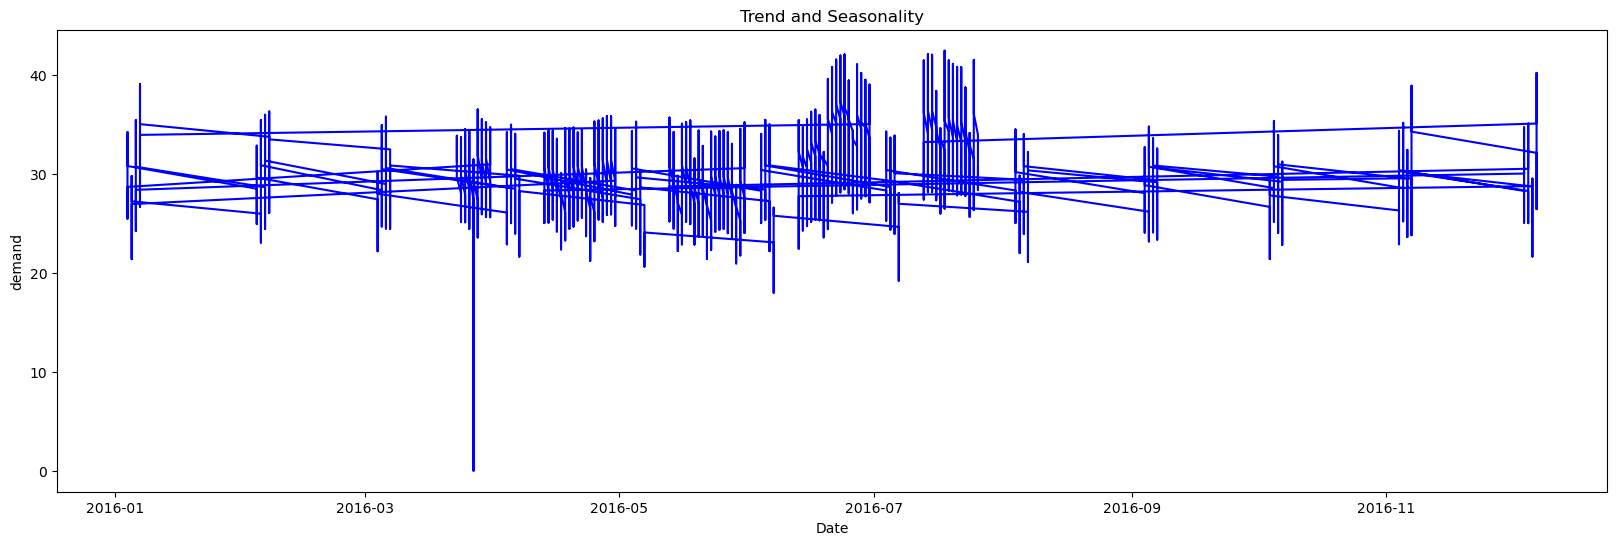

In [ ]:
data1=data[2000:5000]
x = data1['date'].values
y = data1['demand'].values

def plot_df(data1, x, y, title="", xlabel='Date', ylabel='demand', dpi=100):
    plt.figure(figsize=(20,6), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(data1, x=data1['date'], y=data1['demand'], title='Trend and Seasonality')

#### HOW TO UNDERSTAND DATA IS STATIONARY OR NOT? 

There are several quantitative methods we can use to determine if a given series is stationary or not. This can be done using statistical tests called Unit Root Tests. This test checks if a time series is non-stationary and possess a unit root.

There are multiple implementations of Unit Root tests like:

1. Augmented Dickey Fuller test (ADF Test)

2. Kwiatkowski-Phillips-Schmidt-Shin – KPSS test (trend stationary)

3. Philips Perron test (PP Test)

#### AUGMENTED DICKEY FULLER TEST FOR SALES

In [ ]:
# TAKE SAMPLE FROM DATA FOR ADOLF FULLER TEST 

import numpy as np
chosen_idx = np.random.choice(60000, replace=False, size=3000)
df_trimmed = data['demand'].iloc[chosen_idx]

In [ ]:
### AUGMENTED ADOLF FULLER TEST 
from statsmodels.tsa.stattools import adfuller 

adf = adfuller(df_trimmed)
print("\nStatistics analysis\n")
print("Statistic Test : " , adf[0])
print("p-value : " , adf[1])
print("# n_lags : " , adf[2])
print("No of observation: " , adf[3])
for key,value in adf[4].items():
    print(f" critical value {key} : {value}")


Statistics analysis

Statistic Test :  -55.54712011743496
p-value :  0.0
# n_lags :  0
No of observation:  2999
 critical value 1% : -3.43253236279788
 critical value 5% : -2.86250422682754
 critical value 10% : -2.5672832833096195


### NOTE= As we can see p value is 0.0 so we can reject null hypothesis and we can say our data is statitonary.

### AUTOCORELATION AND PARTIAL AUTOCORELATION

Autocorrelation is simply the correlation of a series with its own lags. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

Partial Autocorrelation also conveys similar information but it conveys the pure correlation of a series and its lag, excluding the correlation contributions from the intermediate lags

The common way to test for seasonality of a time series is to plot the series and check for repeatable patterns in fixed time intervals. So, the types of seasonality is determined by the clock or the calendar.

Hour of day

Day of month

Weekly

Monthly

Yearly

However, if we want a more definitive inspection of the seasonality, use the Autocorrelation Function (ACF) plot. There is a strong seasonal pattern, the ACF plot usually reveals definitive repeated spikes at the multiples of the seasonal window.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

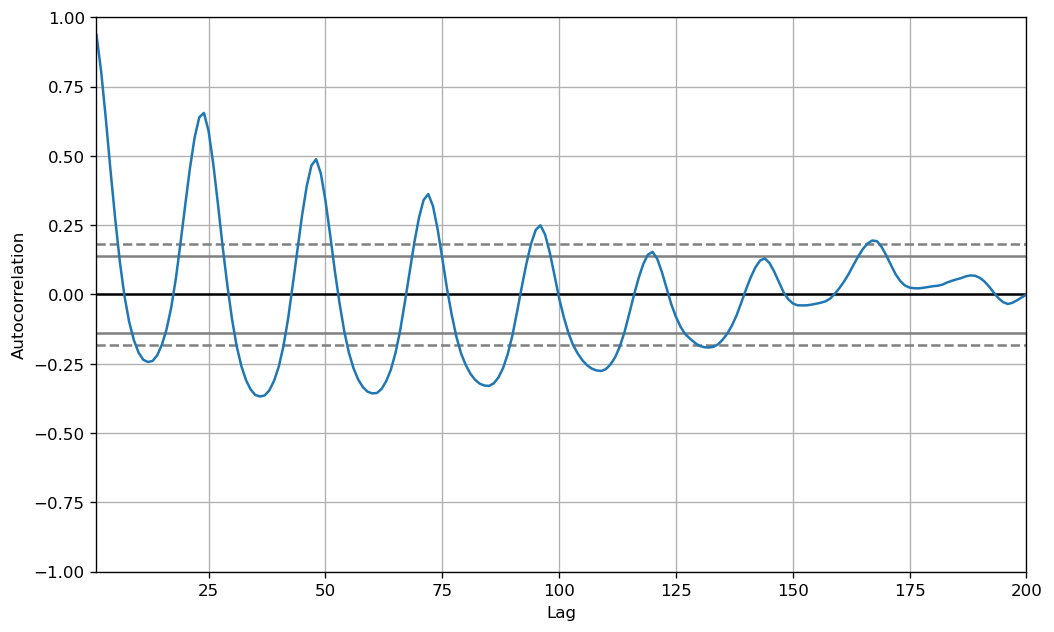

In [ ]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot
x=data['demand'][7300:7500]
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(x.tolist())

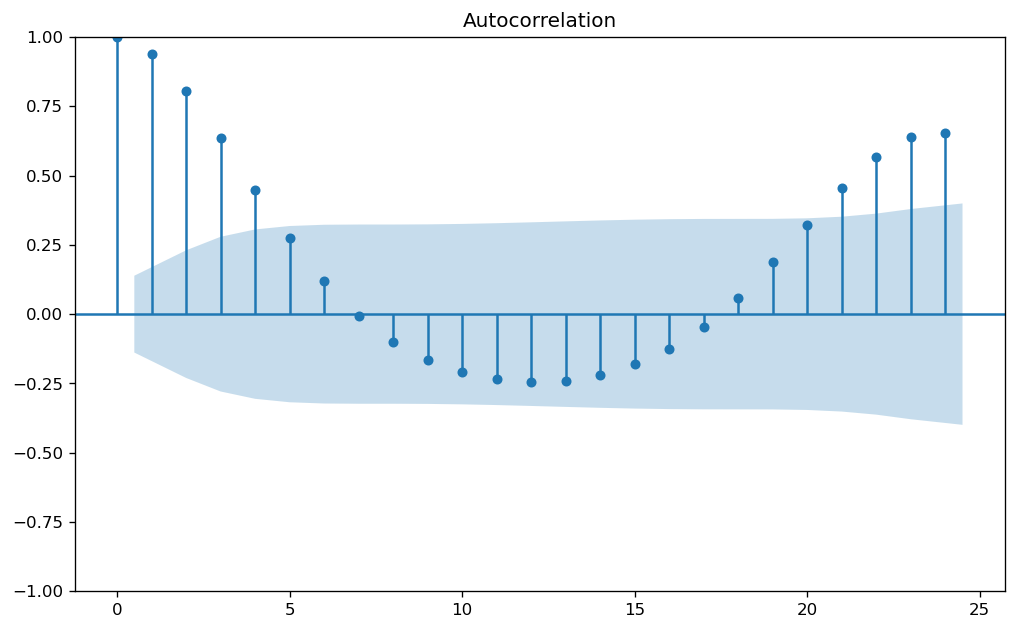

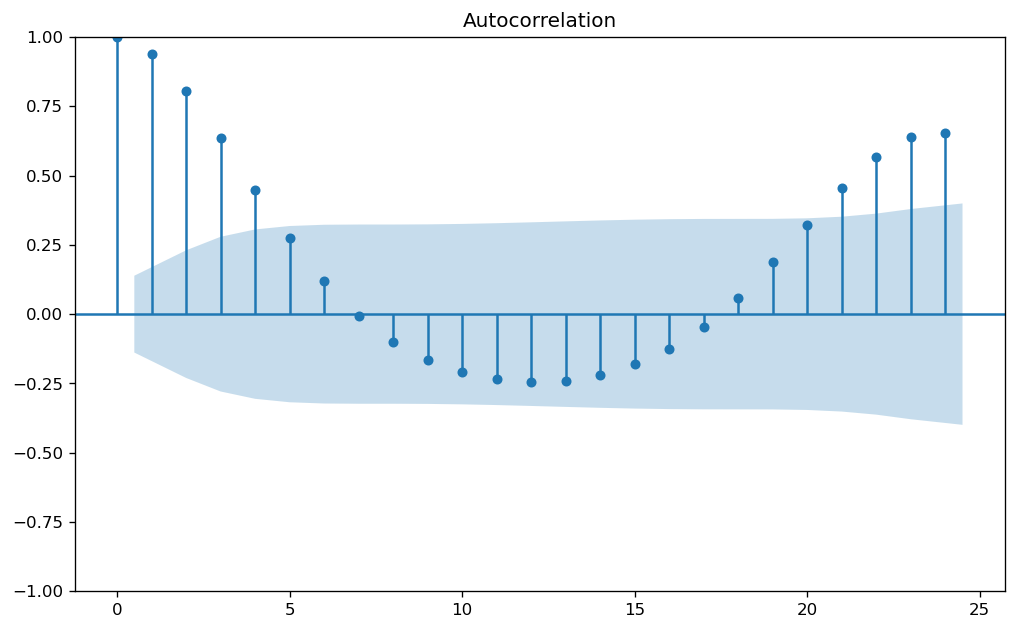

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Draw Plot
plot_acf(x)


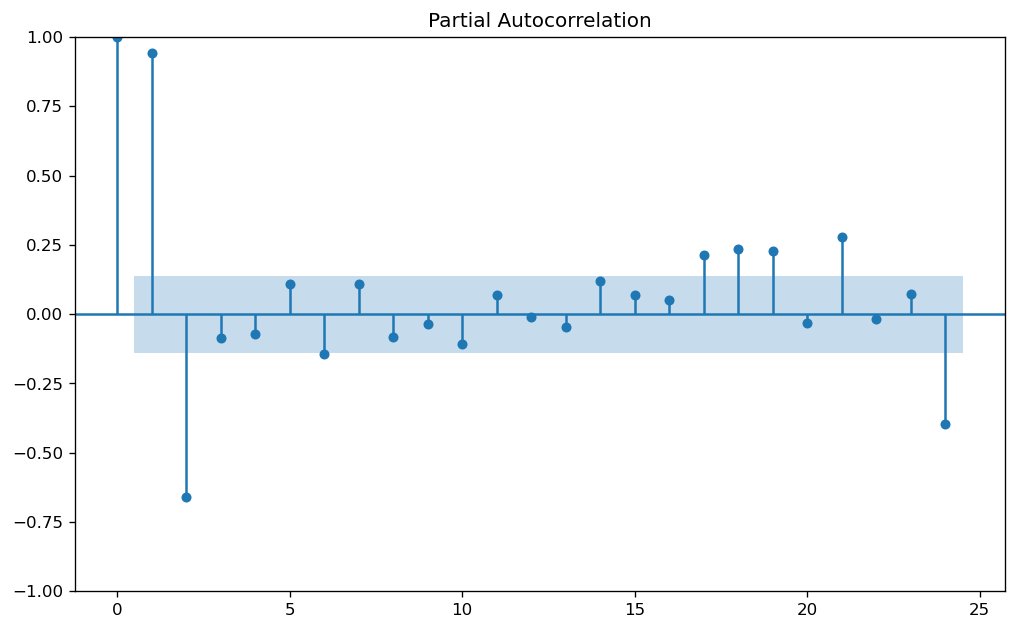

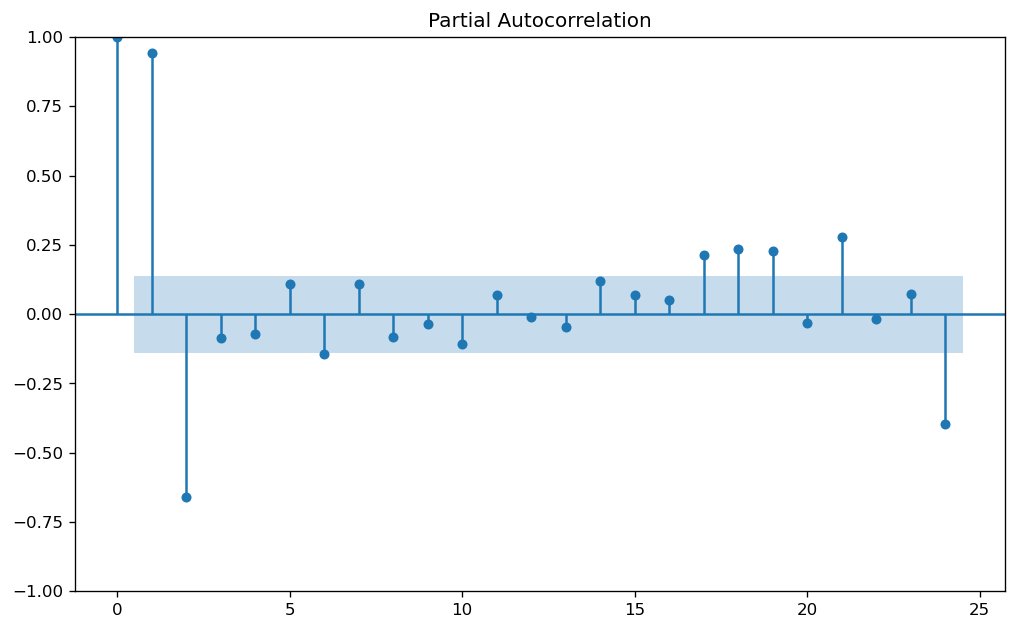

In [ ]:
plot_pacf(x)

#### TEST-2 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

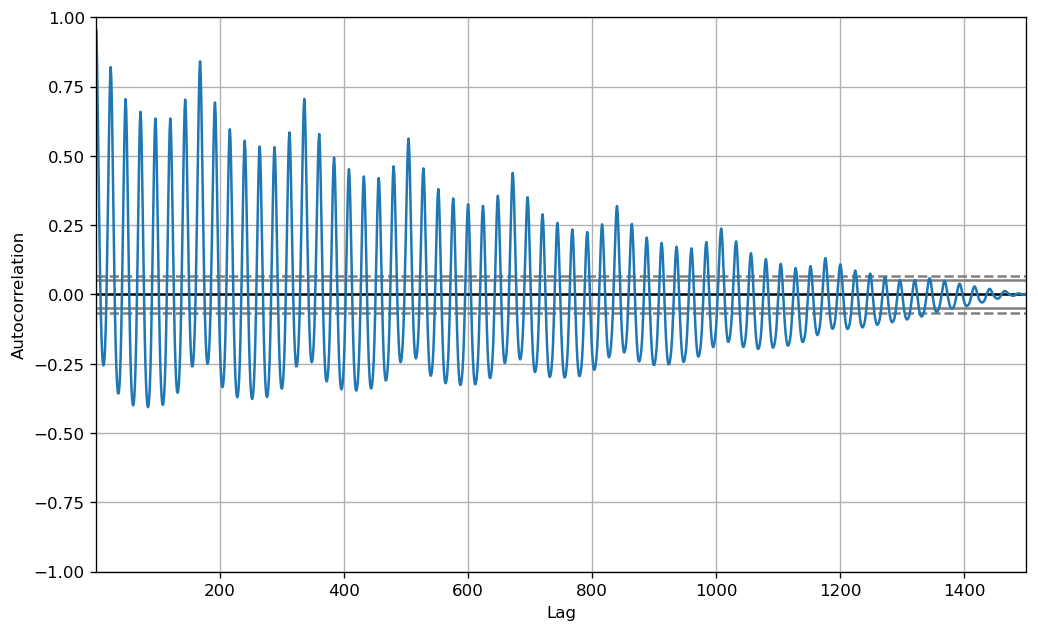

In [ ]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot
x=data['demand'][7000:8500]
# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(x.tolist())

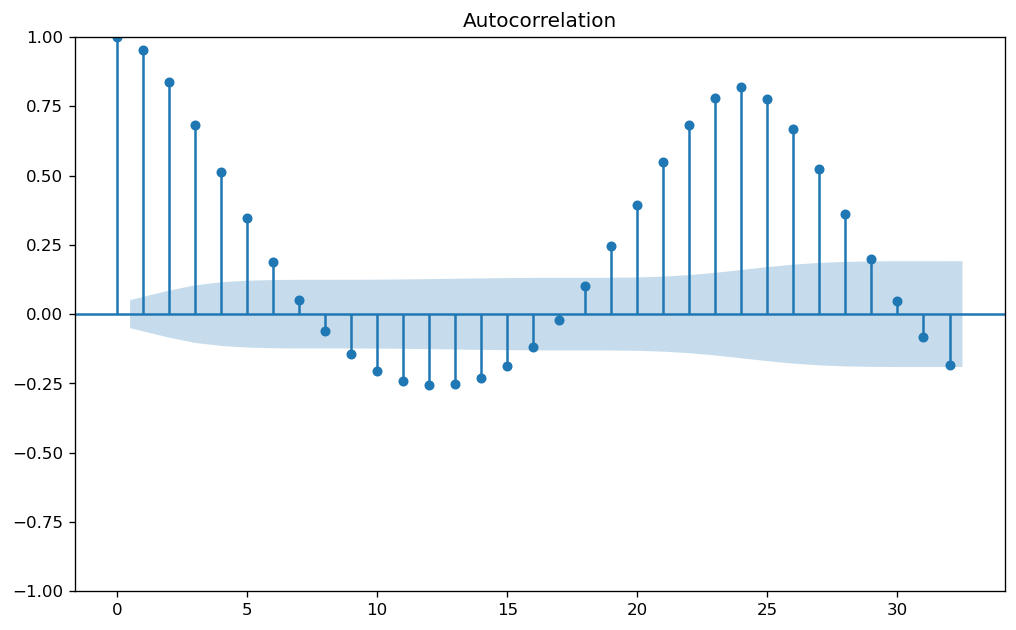

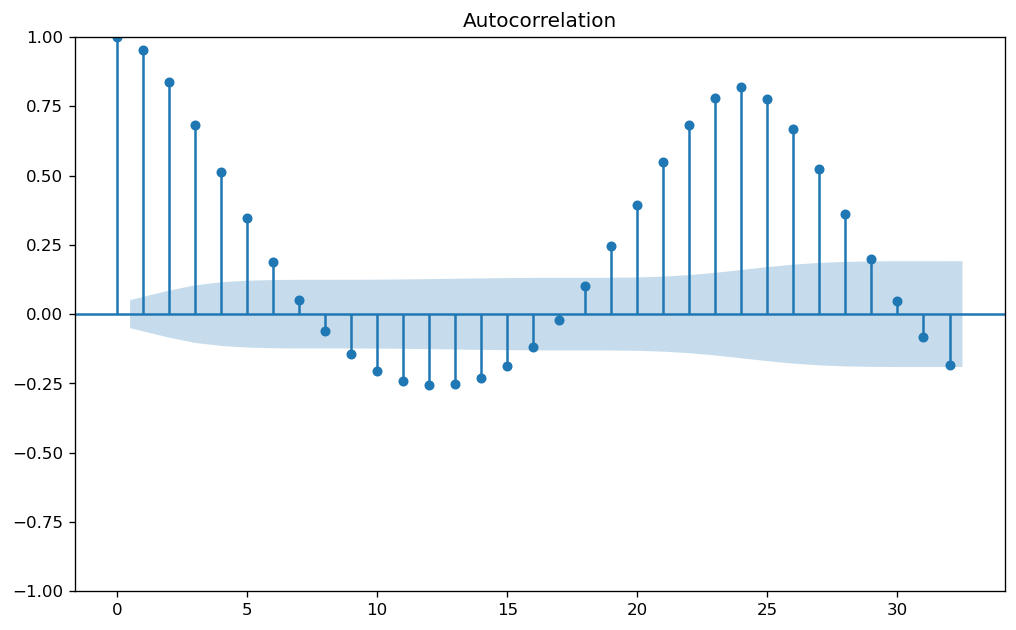

In [ ]:
plot_acf(x)

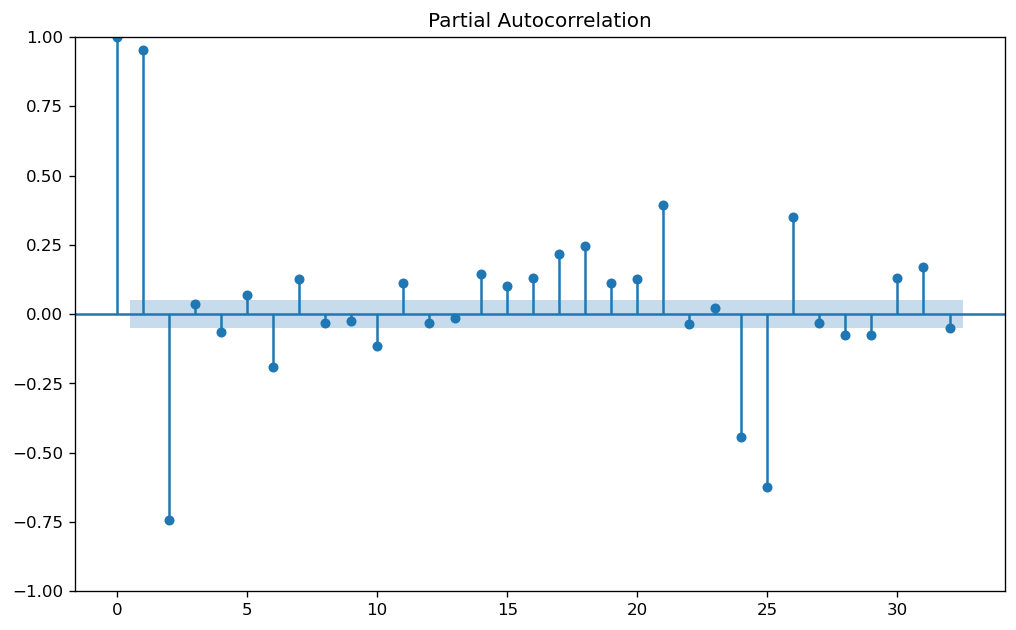

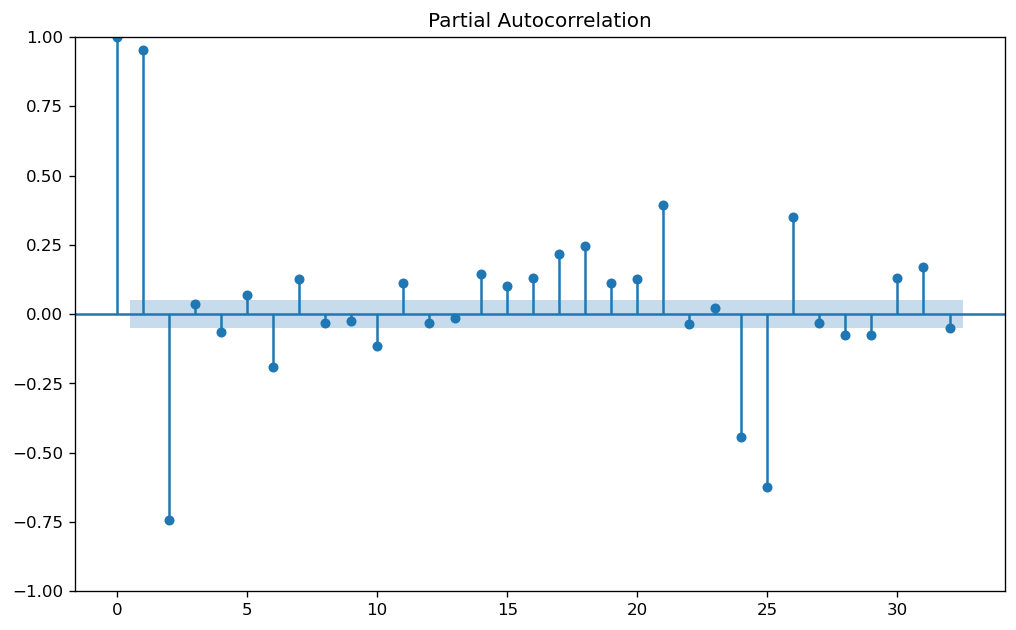

In [ ]:
plot_pacf(x)

### NOTE= Autocorelation did not help us about determining lag size

#### SEASONAL DECOMPOSE

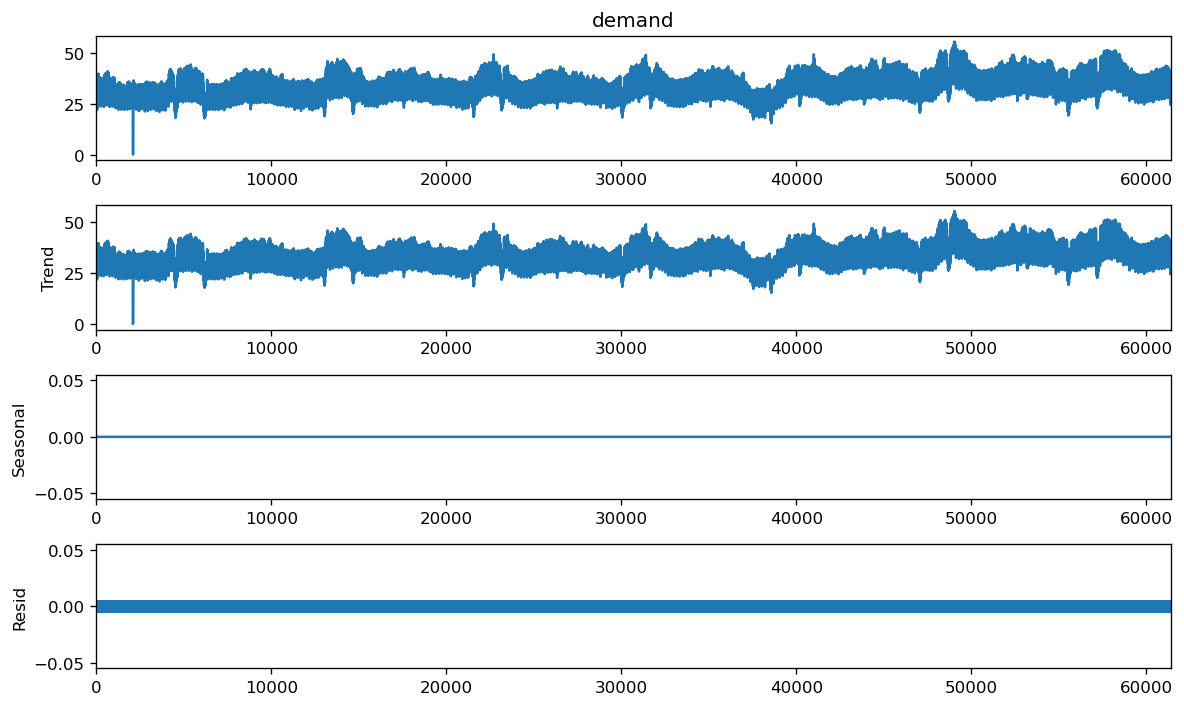

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
sd = seasonal_decompose(data['demand'],model="additive", period=1)
sd.plot()
pyplot.show()

### SARIMA MODEL
Arıma is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

- I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

- MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. And then there is SARIMA and S adds seasonality so SARIMA is what we really need in our case (reference). Using SARIMA requires a bunch of parameters and fortunately there is a pmdarima library to help with this “hyperparameter tuning”. You can refer to the notebook provided in the end for what I did but here are the predictions.

The parameters of the SARIMA model are defined as follows:

- p: The number of lag observations included in the model, also called the lag order.

- d: The number of times that the raw observations are differenced, also called the degree of differencing.

- q: The size of the moving average window, also called the order of moving average.


A SARIMA model can be created using the statsmodels library as follows:

Define the model by calling SARIMA() and passing in the p, d, and q parameters.

The model is prepared on the training data by calling the fit() function.

Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.




In [ ]:
data.head()

,date,hour,demand,new_date,week,month,year
0,2015-12-31,00:00,29.59088,2015-12-31 00:00:00,3,12,365
1,2015-12-31,01:00,27.78543,2015-12-31 01:00:00,3,12,365
2,2015-12-31,02:00,26.51653,2015-12-31 02:00:00,3,12,365
3,2015-12-31,03:00,26.09162,2015-12-31 03:00:00,3,12,365
4,2015-12-31,04:00,25.87154,2015-12-31 04:00:00,3,12,365


In [ ]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61416 entries, 0 to 61415
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      61416 non-null  datetime64[ns]
 1   hour      61416 non-null  object        
 2   demand    61416 non-null  float64       
 3   new_date  61416 non-null  datetime64[ns]
 4   week      61416 non-null  int64         
 5   month     61416 non-null  int64         
 6   year      61416 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 3.3+ MB


In [ ]:
df1=data.drop(['new_date','hour','month','year'],axis=1)
df1.head()

,date,demand,week
0,2015-12-31,29.59088,3
1,2015-12-31,27.78543,3
2,2015-12-31,26.51653,3
3,2015-12-31,26.09162,3
4,2015-12-31,25.87154,3


In [ ]:
df2=df1.drop('week',axis=1)
df2.head()

,date,demand
0,2015-12-31,29.59088
1,2015-12-31,27.78543
2,2015-12-31,26.51653
3,2015-12-31,26.09162
4,2015-12-31,25.87154


In [ ]:
df3=df2.copy()

In [ ]:
df3 = df3.set_index('date')
df3.index = pd.to_datetime(df3.index)


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61416 entries, 2015-12-31 to 2023-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   demand  61416 non-null  float64
dtypes: float64(1)
memory usage: 959.6 KB


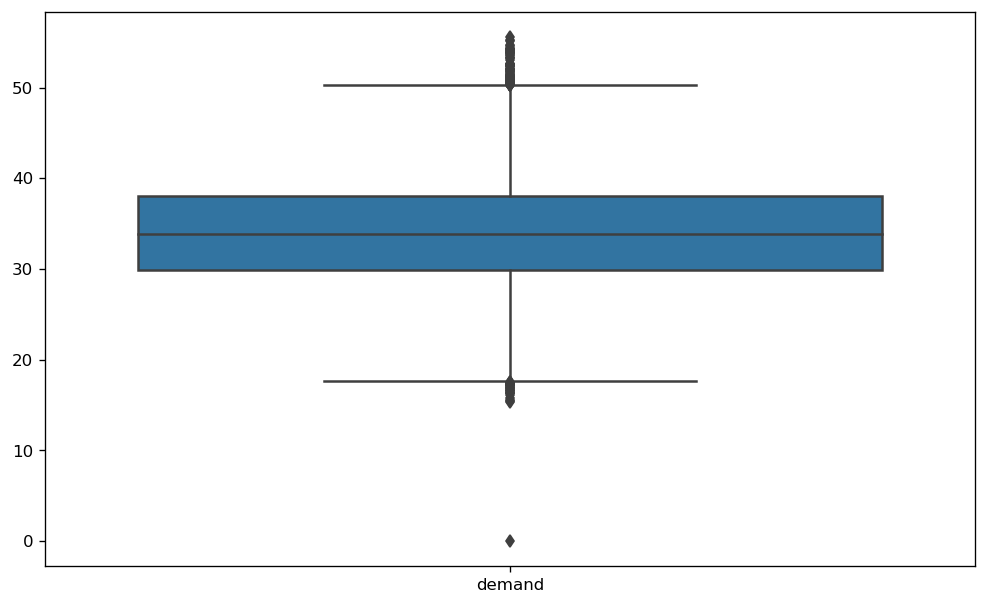

In [ ]:

sns.boxplot(df3)
plt.show()

NOTE= THERE IS NOT TOO MUCH OUTLIERS SO I CAN KEEP THAM 

#### SARIMA MODEL

In [ ]:
my_order = (1, 1, 1)
my_seasonal_order = (1, 1, 1, 12)
# define model
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order, ...)

In [ ]:
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(start=len(data), end=len(data))
# one step forecast
yhat = model_fit.forecast()

In [ ]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(df['demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False) 
print(model_fit.summary())


                                      SARIMAX Results                                      
Dep. Variable:                              demand   No. Observations:                61416
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood              -90856.506
Date:                             Sat, 27 May 2023   AIC                         181721.011
Time:                                     14:57:50   BIC                         181757.113
Sample:                                          0   HQIC                        181732.213
                                           - 61416                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5533      0.003    164.032      0.000       0.547       0.560
ma.L1          0.2192      

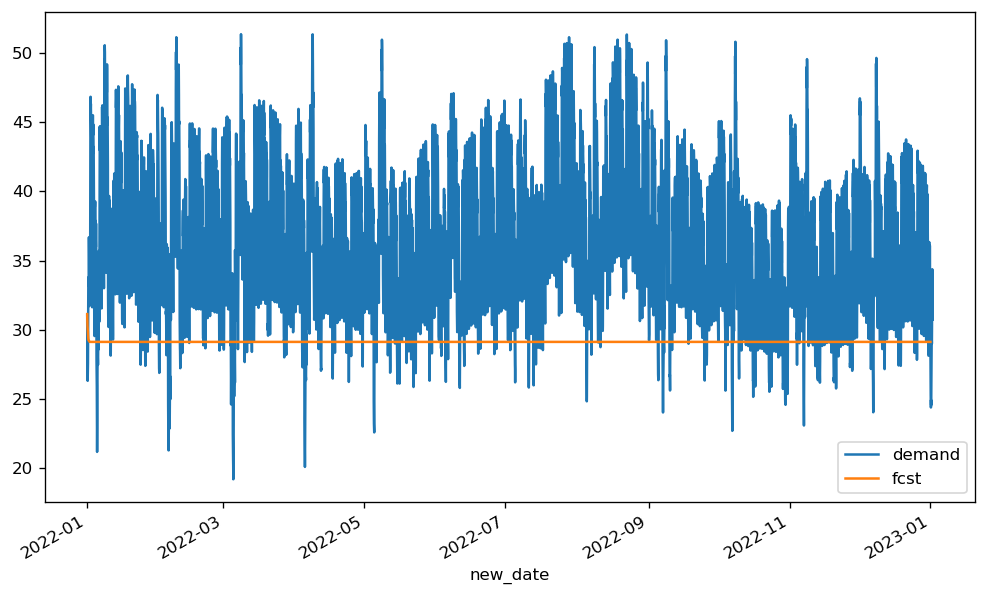

In [ ]:
df['fcst'] = model_fit.predict(start='2022-01-01', end='2023-01-01', dynamic=True)
df[['demand', 'fcst']].loc['2022-01-01':].plot();

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
mse = mean_squared_error(test, fcast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, fcast)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

### XGBOOST PREDICITON 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

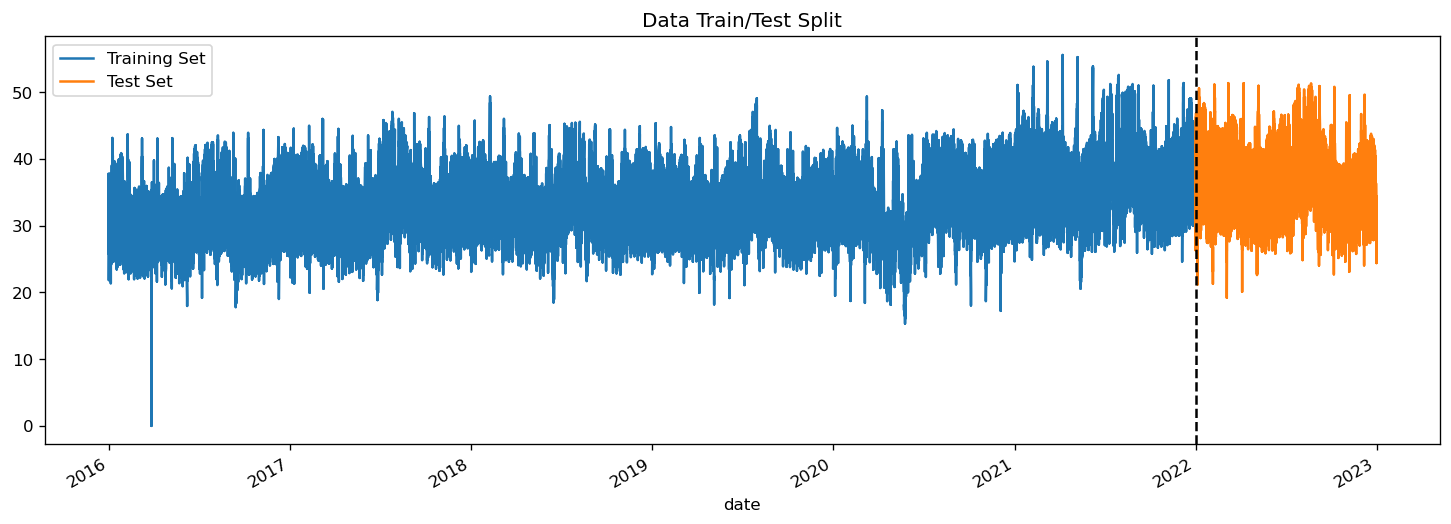

In [ ]:
train = df3.loc[df3.index < '01-01-2022']
test = df3.loc[df3.index >= '01-01-2022']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### TIME SERIES CROSS VALIDATION 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df3 = df3.sort_index()

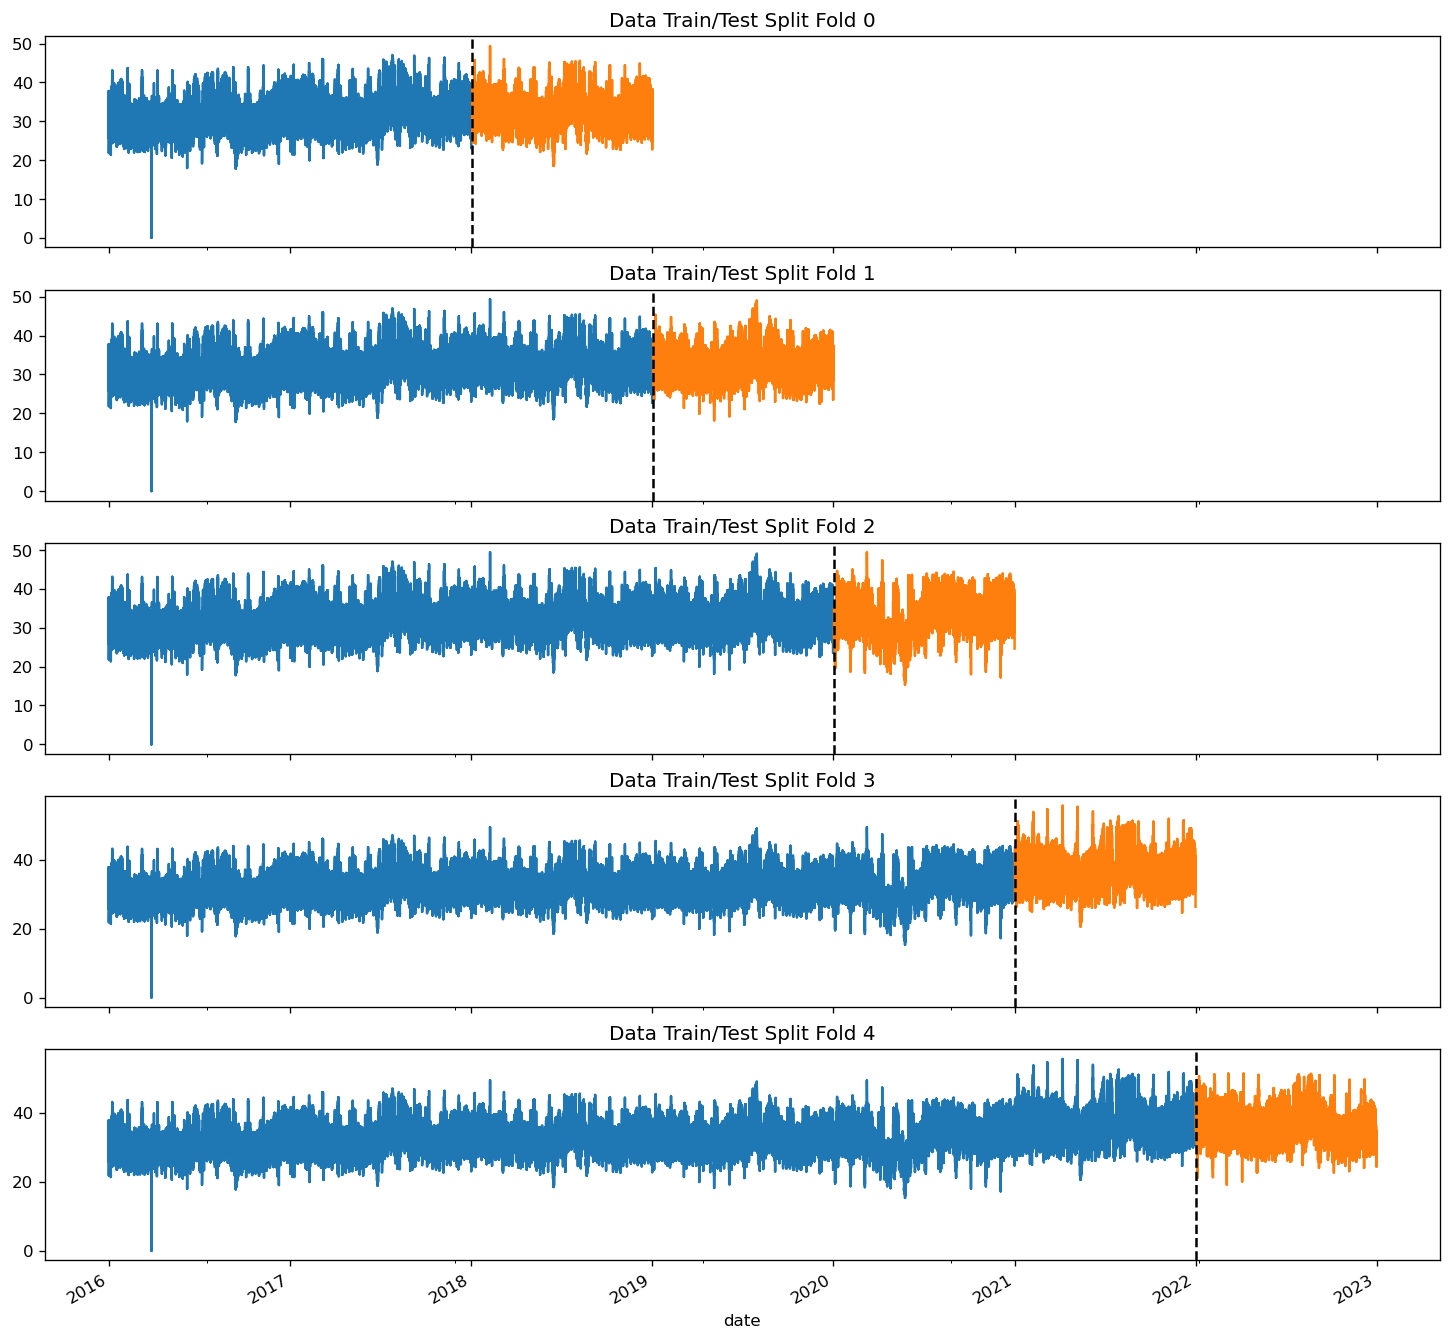

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df3.iloc[train_idx]
    test = df3.iloc[val_idx]
    train['demand'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['demand'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
def create_features(df4):
    """
    Create time series features based on time series index.
    """
    df4 = df3.copy()
    df4['hour'] = df4.index.hour
    df4['dayofweek'] = df4.index.dayofweek
    df4['quarter'] = df4.index.quarter
    df4['month'] = df4.index.month
    df4['year'] = df4.index.year
    df4['dayofyear'] = df4.index.dayofyear
    df4['dayofmonth'] = df4.index.day
    df4['weekofyear'] = df4.index.isocalendar().week
    return df4

df4= create_features(df4)
df4.head()

,demand,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,
2015-12-31,29.59088,0,3,4,12,2015,365,31,53
2015-12-31,27.70582,0,3,4,12,2015,365,31,53
2015-12-31,28.60605,0,3,4,12,2015,365,31,53
2015-12-31,28.96053,0,3,4,12,2015,365,31,53
2015-12-31,30.13836,0,3,4,12,2015,365,31,53


In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df4 = df4.sort_index()

import xgboost as xgb
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df4):
    train = df4.iloc[train_idx]
    test = df4.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year']
    TARGET = 'demand'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[16:18:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.67809	validation_1-rmse:33.67809
[100]	validation_0-rmse:13.19463	validation_1-rmse:13.19463
[200]	validation_0-rmse:6.68721	validation_1-rmse:6.68721
[300]	validation_0-rmse:5.16422	validation_1-rmse:5.16422
[400]	validation_0-rmse:4.88366	validation_1-rmse:4.88366
[500]	validation_0-rmse:4.81503	validation_1-rmse:4.81503
[600]	validation_0-rmse:4.77578	validation_1-rmse:4.77578
[700]	validation_0-rmse:4.73851	validation_1-rmse:4.73851
[800]	validation_0-rmse:4.71435	validation_1-rmse:4.71435
[900]	validation_0-rmse:4.69165	validation_1-rmse:4.69165
[999]	validation_0-rmse:4.67151	validation_1-rmse:4.67151
[16:18:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_o

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 4.6715
Fold scores:[4.671506566502639, 4.671506566502639, 4.671506566502639, 4.671506566502639, 4.671506566502639]


In [ ]:
df4 = create_features(df4)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'demand'

X_all = df4[FEATURES]
y_all = df4[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[16:19:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.67809
[100]	validation_0-rmse:13.19463
[200]	validation_0-rmse:6.68721
[300]	validation_0-rmse:5.16422
[400]	validation_0-rmse:4.88366
[499]	validation_0-rmse:4.81554


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [ ]:
#### EVALUATION MODEL 

In [ ]:
split_date = '01-Jan-2016'
split_date1 = '01-Jan-2020'
split_date2 = '14-Mar-2020'
split_date3 = '15-Mar-2020'
df_train = df.set_index('Date').loc[split_date:'31-Dec-2019', :].reset_index()
df_test = df.set_index('Date').loc[split_date1:split_date2, :].reset_index()

In [ ]:
df_test[['Date','Consumption (MWh)']].set_index('Date').rename(columns={'Consumption (MWh)': 'TEST SET'})\
        .join(df_train[['Date','Consumption (MWh)']].set_index('Date')\
              .rename(columns={'Consumption (MWh)': 'TRAINING SET'}),how='outer').plot(figsize=(25,5), title='Tüketim Miktarı (MWh)', style='.')
plt.ylim(9.8, 10.8)
plt.show()

In [ ]:
df_train.to_csv('energy_cons_train.csv', index = None) #Keeping the train and test data for another notebook :)
df_test.to_csv('energy_cons_test.csv', index = None)

In [ ]:
df_train = df_train.drop(['Date'], axis=1)
df_test = df_test.drop(['Date'], axis=1)

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
y_train = df_train['Consumption (MWh)'].values
X_train = df_train.drop('Consumption (MWh)', axis=1).values

y_test = df_test['Consumption (MWh)'].values
X_test = df_test.drop('Consumption (MWh)', axis=1).values

In [ ]:
model_lgbm = LGBMRegressor(objective='rmse', n_estimators=3000, learning_rate=0.01, num_leaves=36, min_child_samples = 15, 
                           n_jobs=-1,  random_state = None, max_depth = 3, reg_lambda = 0.0, reg_alpha = 0.0, min_split_gain=0.0)
eval_set_ALLRESTS = [(X_train, y_train), (X_test, y_test)]
model_lgbm.fit(X_train, y_train, eval_set = eval_set_ALLRESTS ,eval_metric='rmse', early_stopping_rounds=15, verbose=20)

In [ ]:
from matplotlib import pyplot
# retrieve performance metrics
results = model_lgbm.evals_result_
epochs = len(results['training']['rmse'])
x_axis = range(0, epochs)
# plot MAE
plt.figure(figsize=(17,8))
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['training']['rmse'], label='Train')
ax.plot(x_axis, results['valid_1']['rmse'], label='Validation')
ax.legend();
pyplot.ylabel('RMSE')
pyplot.xlabel('# of iterations (or # of estimators)')
pyplot.title('LGBM RMSE')
pyplot.show()

#### FEATURE IMPORTANCE

In [ ]:
importances = pd.Series(data=model_lgbm.feature_importances_,
                        index= df_train.drop('Consumption (MWh)', axis=1).columns)

# Sort importances
importances_sorted = importances.sort_values()
plt.figure(figsize=(12,20))
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Features Importances')
plt.show()

### CREATE FUTURE DATE AND MAKE PREDICITON WITH XGBOOST

In [ ]:
# Create future dataframe
future = pd.date_range('2023-06-02','2023-09-01', freq='1h')
df5 = pd.DataFrame(index=future)
df5

""
2023-06-02 00:00:00
2023-06-02 01:00:00
2023-06-02 02:00:00
2023-06-02 03:00:00
2023-06-02 04:00:00
...
2023-08-31 20:00:00
2023-08-31 21:00:00
2023-08-31 22:00:00
2023-08-31 23:00:00


In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df5= create_features(df5)
df5.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2023-06-02 00:00:00,0,4,2,6,2023,153,2,22
2023-06-02 01:00:00,1,4,2,6,2023,153,2,22
2023-06-02 02:00:00,2,4,2,6,2023,153,2,22
2023-06-02 03:00:00,3,4,2,6,2023,153,2,22
2023-06-02 04:00:00,4,4,2,6,2023,153,2,22


In [ ]:
df5['pred'] = reg.predict(df5[FEATURES])

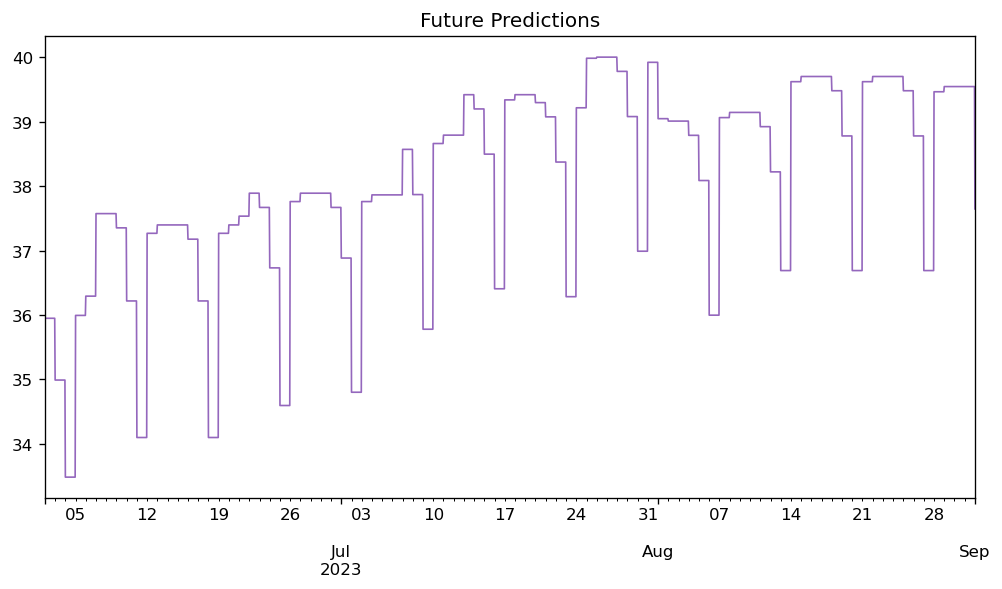

In [ ]:
color_pal = sns.color_palette()
df5['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [ ]:
# Save model
#reg.save_model('Desktop/data-analytics-HW1/ads577-final-project/xgb_model.json')

### PREDICTION MODEL WITH LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.activations import relu, selu, gelu
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Reshape, Flatten
from tensorflow.keras.layers import LSTM, GRU, RNN
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from math import floor
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import make_scorer, accuracy_score

from sklearn.model_selection import StratifiedKFold

### Scaling data

In [ ]:
data = (df3 - df3.mean())/df3.std()

NameError: name 'df3' is not defined

### Defining Lag for prediciton 

In [ ]:
def sliding_window(data, window_size = 30):
    data = np.array(data)
    N = len(data)
    X = []
    y = []
    for i in range(N-1-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [ ]:
X, y = sliding_window(data)

In [ ]:
alpha = 0.8
N = len(data)
cut_off = int(alpha*N)
X_train, y_train = sliding_window(data[:cut_off])
X_test, y_test = sliding_window(data[cut_off:])

In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

In [ ]:
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [ ]:
lstm1_layer_size=list()
lstm1_r2_scores=list()

In [ ]:
for i in range(150,750,150): 
    lstm1_layer_size.append(i)   
    model = Sequential([LSTM(i),
                        Dense(i,activation='gelu'),
                        Dropout(0.4),
                        Dense(i,activation='gelu'),
                        Dense(1)])
    model.compile(loss='mse',optimizer='adam')
    model.fit(X_train,y_train,batch_size=500,epochs=20,validation_data=(X_test,y_test))
    y_pred = model.predict(X_test)
    y_pred = y_pred.reshape(-1)
    scores=r2_score(y_test, y_pred)
    lstm1_r2_scores.append(scores)

In [ ]:
lstm1_dict= dict(zip(lstm1_layer_size,lstm1_r2_scores))
print('LSTM with window size:150')
print(lstm1_dict)
  

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(12,12),dpi=100)
for i in range(len(lstm1_r2_scores)):
    x=i//2
    y= i %2
    sns.lineplot(y_pred[:500], label = "pred",c='blue', ax=ax[x,y])
    sns.lineplot(y_test[:500], label = "real",c='red',ax=ax[x,y])
    ax[x,y].xaxis.label.set_size(15)
    ax[x,y].yaxis.label.set_size(15)
plt.legend()
plt.show()

In [ ]:
y_pred_test = model.predict(x_test)
# invert predictions
y_pred_train =scaler.inverse_transform(y_pred_train)
trainy = scaler.inverse_transform([y_train])
y_pred_test= scaler.inverse_transform(y_pred_test)
testy =scaler.inverse_transform([y_test])
# calculate root mean squared error
y_train_score= math.sqrt(mean_squared_error(trainy[0], y_pred_train[:,0]))
print('Train Score: %.2f RMSE' % (y_train_score))
y_test_score= math.sqrt(mean_squared_error(testy[0], y_pred_test[:,0]))
print('Test Score: %.2f RMSE' % (y_test_score))

In [ ]:
# shift train predictions for plotting look_back=window size
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_pred_train)+look_back, :] = y_pred_train
# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_pred_train)+(look_back*2)+1:len(df)-1, :] = y_pred_test 
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### PREDICTION MODEL WITH GRU

GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

In [ ]:
gru1_layer_size=list()
gru1_r2_scores=list()

In [ ]:
for i in range(150,750,150): 
  gru1_layer_size.append(i)   
  model = Sequential([GRU(i),
                       Dense(i,activation='gelu'),
                       Dropout(0.4),
                       Dense(i,activation='gelu'),
                       Dropout(0.4),
                       Dense(1)])
  model.compile(loss='mse',optimizer='adam')
  model.fit(X_train,y_train,batch_size=500,epochs=20,validation_data=(X_test,y_test))
  y_pred = model.predict(X_test)
  y_pred = y_pred.reshape(-1)
  scores=r2_score(y_test, y_pred)
  gru1_r2_scores.append(scores)

In [ ]:
gru1_dict= dict(zip(gru1_layer_size,gru1_r2_scores))
print('GRU with window size: 150')
print(gru1_dict)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(12,12),dpi=100)
for i in range(len(gru1_r2_scores)):
  x=i//2
  y= i %2
  sns.lineplot(y_pred[:500], label = "pred",c='blue', ax=ax[x,y])
  sns.lineplot(y_test[:500], label = "real",c='black',ax=ax[x,y])
  ax[x,y].xaxis.label.set_size(15)
  ax[x,y].yaxis.label.set_size(15)
plt.legend()
plt.show()

#### COMPARE ALL NEURAL NETWORKS MODEL

In [ ]:
lstm_dict= {}
lstm_dict.update(lstm1_dict)
lstm_dict.update(lstm2_dict)
lstm_dict

In [ ]:
lstm_df = pd.DataFrame(lstm_dict.items(), columns=['Neuron of LSTM', 'R2 score of LSTM'])
lstm_df

In [ ]:
gru_dict= {}
gru_dict.update(gru1_dict)
gru_dict.update(gru2_dict)
gru_dict

In [ ]:
gru_df = pd.DataFrame(gru_dict.items(), columns=['Neuron of GRU', 'R2 score of GRU'])
gru_df


In [ ]:
gru_df.to_excel('gru-scores.xlsx', sheet_name = 'New_sheet')

### RNN MODEL 

In [ ]:
#RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))
rnn_model.add(Dense(1))
rnn_model.summary()
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

In [ ]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

In [ ]:
# compare the actual values vs predicted values by plotting a graph

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16, 4))
    plt.plot(test, color='blue', label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange', label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [ ]:
### LSTM2 

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

In [ ]:
#r2 score for the values predicted by the above trained LSTM model
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

In [ ]:
#actual values vs predicted values by plotting a graph
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [ ]:
### PLOT RNN AND LSTM TOGETHER

In [ ]:
#RNN, LSTM model by plotting data in a single graph
plt.figure(figsize=(15,8))
plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="blue", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()